# Testing the PILCO framework

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [51]:
# Enable Float64 for more stable matrix inversions.
import jax
from jax import Array, config
import jax.numpy as jnp
from jax.tree_util import Partial
import numpy as np
import jax.random as jr
from jaxtyping import ArrayLike, install_import_hook, Array, Float, Int, PyTree  
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

key = jr.key(123)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
import gymnasium as gym

In [4]:
from controllers import RandomController, Sum_of_Sinusoids, set_sos_params, LinearPolicy
from model_learning.gp_models import MGPR

In [5]:
import optax as ox

from typing import Tuple

In [6]:
from IPython import display

# Functions

In [7]:
def cart_pole_cost(
    states_sequence: ArrayLike, 
    target_state: ArrayLike = jnp.array([jnp.pi,0.0]), 
    lengthscales: ArrayLike = jnp.array([3.0,1.0]),
    angle_index:int = 2,
    pos_index:int = 0
)->Array:
    """
    Cost function given by the combination of the saturated distance between |theta| and 'target angle', and between x and 'target position'.
    """
    x = states_sequence[pos_index]
    theta = states_sequence[angle_index]

    target_x = target_state[1]
    target_theta = target_state[0]

    return 1 - jnp.exp(
        -(jnp.square((jnp.abs(theta) - target_theta) / lengthscales[0])) - jnp.square((x - target_x) / lengthscales[1])
    )

## Globals

In [8]:
num_particles = 400

In [9]:
num_trials = 5
T_sampling = 0.05
T_exploration = 3.0
T_control = 3.0
sim_timestep = 0.1

## Generate the environments

In [10]:
env = gym.make("InvertedPendulum-v5")
env_test = gym.make("InvertedPendulum-v5", render_mode='rgb_array')

In [11]:
action_dim = env.action_space.shape[0]
x, _ = env.reset()
state_dim = x.shape[0]
num_basis = 200
umax = 3.0
#policy = LinearPolicy(state_dim, action_dim, True, umax)

In [12]:
# Initialize a random controller
exploration_policy = RandomController(state_dim,action_dim,True,3.0)

In [13]:
# Randomly sample some points
key = jr.key(42)
x, _ = env.reset()
states = [x]
key, subkey = jr.split(key)
#u = env.action_space.sample()
u = exploration_policy(x,0,subkey)
actions = [u]

for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env.step(np.array(u))
    x = z[0]
    states.append(x)
    key, subkey = jr.split(key)
    #u = env.action_space.sample()
    u = exploration_policy(x,timestep,subkey)
    actions.append(u)

In [14]:
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))

In [15]:
-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0])

Array(14.90914297, dtype=float64)

In [16]:
# Should vmap the optimization
model.optimize()

In [17]:
-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0])

Array(-86.66948246, dtype=float64)

### Rollout

In [18]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial action
u = exploration_policy(x,timestep,subkey)

In [19]:
# initialize some particles
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [20]:
policy = LinearPolicy(state_dim, action_dim, True, umax)

In [24]:
import equinox as eqx

In [42]:
@eqx.filter_jit
@eqx.debug.assert_max_traces(max_traces=1)
def rollout(
    policy: eqx.Module,
    init_samples: ArrayLike,
    model: eqx.Module,
    timesteps: ArrayLike,
    key: ArrayLike = jr.key(123),
)->float:
    policy_params, policy_static = eqx.partition(policy, eqx.is_array)
    
    def one_rollout_step(carry, t):
        policy_params, key, samples, total_cost = carry
        policy = eqx.combine(policy_params, policy_static)
        actions = jax.vmap(policy)(samples,jnp.tile(t,num_particles))
    
        key, subkey = jr.split(key)
        samples = model.get_samples(key, samples, actions, 1)
        cost = jnp.sum(jax.vmap(cart_pole_cost)(jnp.hstack((samples, actions))))
        return (policy_params,key,samples,total_cost+cost), cost
    
    total_cost = 0
    (policy_params,key,samples,total_cost), result = jax.lax.scan(
        one_rollout_step, (policy_params,key,init_samples,total_cost), timesteps
    )
    return total_cost/len(timesteps)

In [43]:
control_horizon = int(T_control/T_sampling)

In [44]:
%%time
rollout(policy,initial_particles,model,jnp.arange(control_horizon))

CPU times: user 582 ms, sys: 62.1 ms, total: 644 ms
Wall time: 255 ms


Array(310.80594468, dtype=float64)

In [49]:
optimizer = ox.adam(learning_rate=ox.linear_schedule(init_value=1e-2, end_value=1e-6, transition_steps=100))

In [61]:
def fit_controller(  # noqa: PLR0913
    *,
    policy: eqx.Module,
    samples: ArrayLike,
    timesteps: ArrayLike,
    gp_model: eqx.Module,
    optim: ox.GradientTransformation,
    key: ArrayLike = jr.PRNGKey(42),
    num_iters: int = 100,
    unroll: int = 5,
)->Tuple[eqx.Module,Array]:
    
    opt_state = optim.init(eqx.filter(policy,eqx.is_array))
    
    # Mini-batch random keys to scan over.
    iter_keys = jr.split(key, num_iters)
    
    # Optimisation step.
    @eqx.filter_jit
    def make_step(
        policy: eqx.Module,
        opt_state: PyTree,
    )->Tuple[eqx.Module,PyTree, float]:
        loss_value, loss_gradient = eqx.filter_value_and_grad(rollout)(policy,samples,gp_model,timesteps)
        updates, opt_state = optim.update(loss_gradient, opt_state, eqx.filter(policy, eqx.is_array))
        policy = eqx.apply_updates(policy, updates)
        return policy, opt_state, loss_value
    
    # Optimisation loop.
    #(return_policy, _), history = jax.lax.scan(step, (policy, opt_state), (iter_keys), unroll=unroll)
    for step in range(num_iters):
        policy, opt_state, train_loss = make_step(policy,opt_state)
        if (step % 100) == 0 or (step == num_iters - 1):
            print(
                f"{step=}, train_loss={train_loss.item()}, "
            )
        

    #return return_policy, history
    return policy

In [62]:
%%time
policy = fit_controller(
    policy=policy,
    samples=initial_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    optim=optimizer,
    num_iters=1000
)

step=0, train_loss=310.805944676038, 
step=100, train_loss=286.0337723402651, 
step=200, train_loss=286.0285981737515, 
step=300, train_loss=286.0234812556697, 
step=400, train_loss=286.0183832524752, 
step=500, train_loss=286.0132939653742, 
step=600, train_loss=286.0082094419219, 
step=700, train_loss=286.00312777742965, 
step=800, train_loss=285.99804792200655, 
step=900, train_loss=285.99296924131454, 
step=999, train_loss=285.9879421020233, 
CPU times: user 1min 34s, sys: 1min 45s, total: 3min 19s
Wall time: 39.1 s


In [64]:
params = eqx.filter(policy,eqx.is_array)

In [67]:
params.phi, params.offset

(Array([[0.24632846, 0.65982197, 0.70410214, 0.76221338]], dtype=float64),
 Array([[0.68457738]], dtype=float64))

In [68]:
new_params = eqx.filter(new_policy,eqx.is_array)

In [69]:
new_params.phi, new_params.offset

(Array([[0.49488659, 1.09264719, 1.24826368, 1.30008048]], dtype=float64),
 Array([[1.03776657]], dtype=float64))

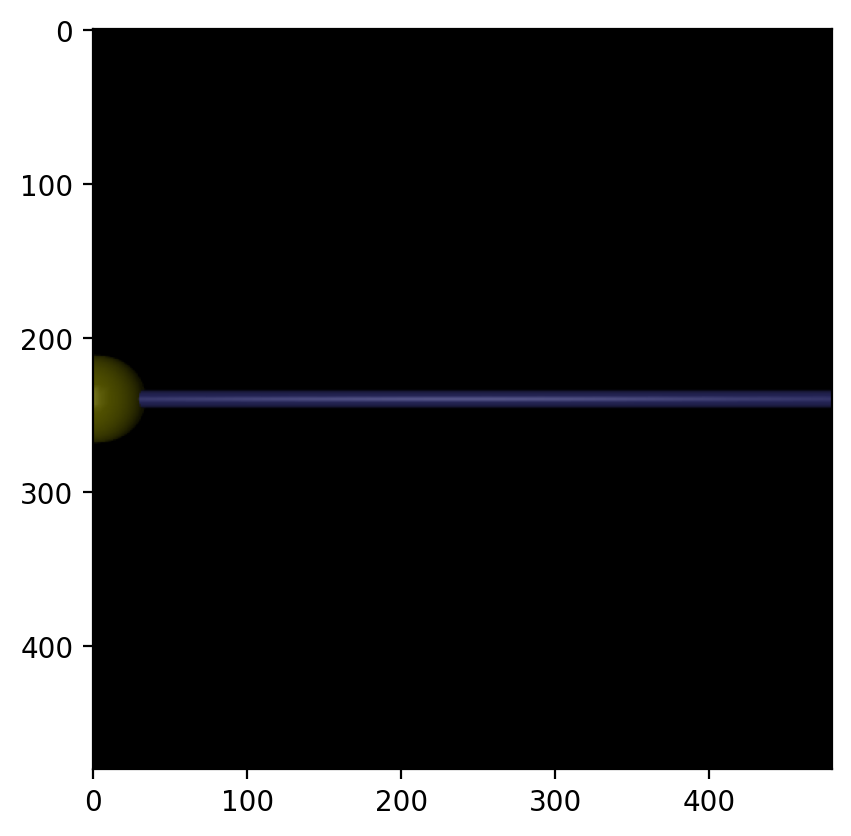

In [70]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = policy(x,timestep,subkey)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = policy(x,timestep,subkey)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [72]:
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))
model.optimize()
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))

8.019310336036657
-119.88180930274531


In [73]:
len(states)

64

In [74]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = exploration_policy(x,timestep,subkey)

In [75]:
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [34]:
objective_fun = Partial(rollout,init_samples=initial_particles,model=model,timesteps=timesteps)

In [35]:
%%time
policy,history = fit_controller(policy=policy,objective=objective_fun,optim=optimizer,num_iters=100)

CPU times: user 2min 10s, sys: 14 s, total: 2min 24s
Wall time: 1min 33s


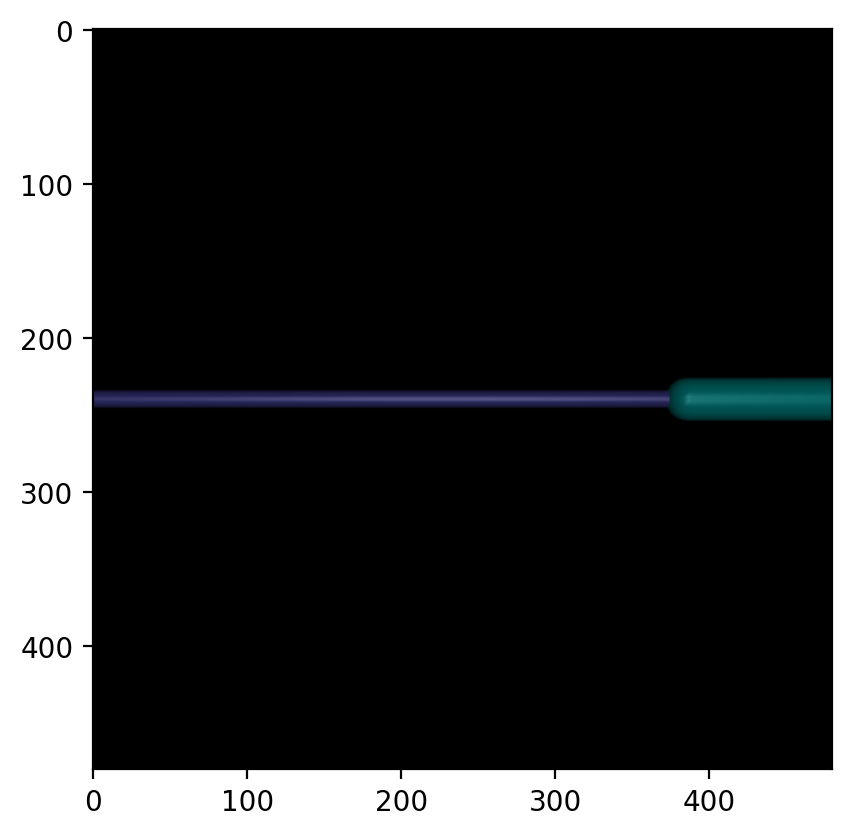

In [36]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = policy(x,timestep,subkey)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = policy(x,timestep,subkey)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [39]:
model = DynamicalModel(states=jnp.array(states),actions=jnp.array(actions))
model.optimize()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = exploration_policy(x,timestep,subkey)

In [41]:
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [42]:
objective_fun = Partial(rollout,init_samples=initial_particles,model=model,timesteps=timesteps)

In [43]:
%%time
policy,history = fit_controller(policy=policy,objective=objective_fun,optim=optimizer,num_iters=100)

CPU times: user 3min 26s, sys: 20 s, total: 3min 46s
Wall time: 2min 28s


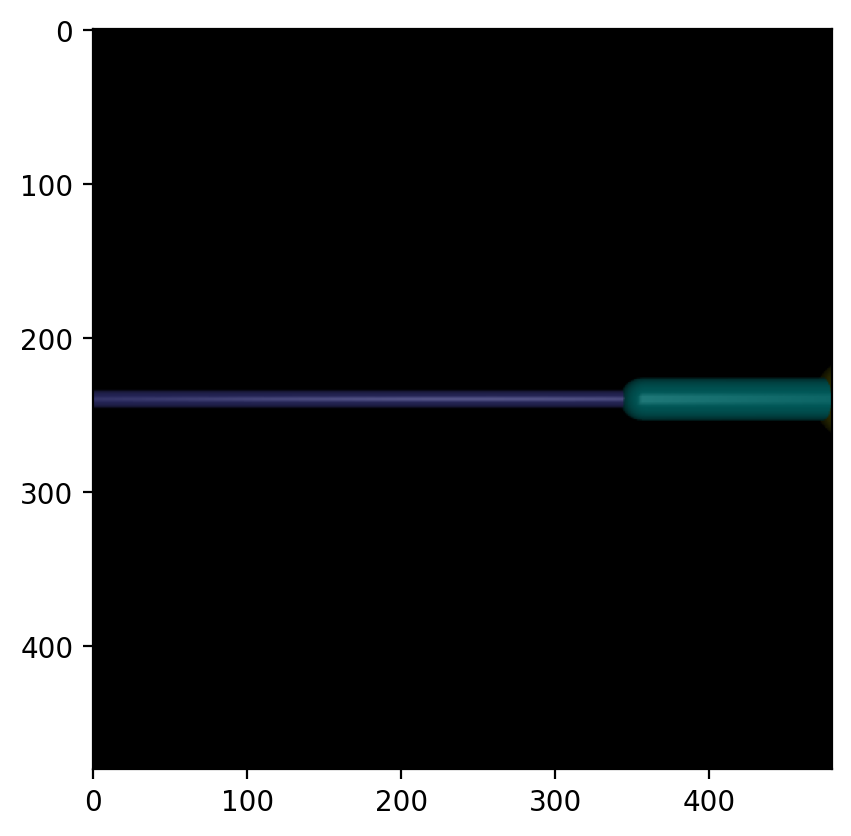

In [45]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = policy(x,timestep,subkey)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = policy(x,timestep,subkey)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [48]:
import random
import string

def generate_random_string(length):
    characters = string.ascii_letters + string.digits
    return ''.join(random.choice(characters) for i in range(length))

random_string = generate_random_string(100)
print(random_string)

It01hSlVj40SnZLMTTIgZo46LwxLCVg7w28u7y0iquLeqvI6WEKApkgBfBgHk3BeZodKUnUFG9qoldAZbR3NZ4iREGfJrytkgmSr


In [49]:
random_string[-80:]

'Zo46LwxLCVg7w28u7y0iquLeqvI6WEKApkgBfBgHk3BeZodKUnUFG9qoldAZbR3NZ4iREGfJrytkgmSr'

In [49]:
np.random.uniform(-5, 5, (100, 2)).shape

(100, 2)

In [50]:
x_grid, y_grid = np.linspace(-5, 5, 100), np.linspace(-5, 5, 50)
x_, y_ = np.meshgrid(x_grid, y_grid)
X_pred = np.vstack((x_.flatten(), y_.flatten())).T

In [52]:
X_pred.shape

(5000, 2)